<div style="text-align:center; font-size:26px; color:green;">Estrategia con Bollinger Bands</div>

Si no compartes el conocimiento no sirve para nada. [Michio Kaku](https://www.youtube.com/watch?v=6rDxlolYUQw)



# Lógica y definición de la estrategia.

La estrategia Bollinger Bands es una técnica utilizada en el análisis técnico del mercado de valores.  La estrategiase basa en la idea de que los precios tienden a volver a su media y que los movimientos extremos por encima o por debajo de las bandas pueden ser señales de posibles cambios en la dirección del mercado. 

* **Método calculate_bollinger_bands:** Este método calcula las bandas de Bollinger, que son un indicador de volatilidad que consiste en una banda central (media móvil simple) y dos bandas exteriores (una por encima y otra por debajo de la media móvil simple) que se calculan sumando y restando un múltiplo del desviación estándar de los precios de cierre. Las bandas exteriores se utilizan para identificar niveles potenciales de sobrecompra y sobreventa en el mercado.

* **Método calculate_entry_exit_points:** Este método utiliza las bandas de Bollinger calculadas previamente para determinar los puntos de entrada y salida del mercado. Cuando el precio de cierre cae por debajo de la banda inferior, se considera una señal de compra (entrada), ya que sugiere que el mercado está sobrevendido. Por otro lado, cuando el precio de cierre sube por encima de la banda superior, se considera una señal de venta (salida), ya que sugiere que el mercado está sobrecomprado. El método devuelve un DataFrame que contiene las fechas y los puntos de entrada y salida calculados.

In [1]:
# Clase para implementar la estrategia con EMA's, todo en una clase.
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objs as go 
from plotly.subplots import make_subplots

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')


class CalculateBollinger_Bands:
    def __init__(self, ticker, start_date, end_date, window, n_std):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.window = window
        self.n_std = n_std
        self.calculate_entry_exit_points()  # Calcular puntos de entrada y salida
        self.calculate_invest_evolution()   # Calcular evolución de la inversión

    def get_quotes(self):
        try:
            # Descarga los precios de cierre utilizando yfinance
            self.closing_quotes = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False)

            # Formatea el índice como "yy-mm-dd" y conviértelo a un DatetimeIndex
            self.closing_quotes.index = pd.to_datetime(self.closing_quotes.index.strftime('%y-%m-%d'), format='%y-%m-%d')

            # Redondea los precios de cierre a dos decimales
            self.closing_quotes['Close'] = self.closing_quotes['Close'].round(2)

            # Crea una copia del DataFrame solo con la columna "Close"
            self.close_df = self.closing_quotes[['Close']].copy(deep=True)

        except Exception as e:  # Captura una excepción más amplia
            raise ValueError(f"No se pudo descargar los datos para {self.ticker} utilizando yfinance: {e}")

    def calculate_bollinger_bands(self):
        self.sma = self.close_df["Close"].rolling(self.window).mean()
        self.std = self.close_df["Close"].rolling(self.window).std()
        self.upper_band = self.sma + self.n_std * self.std
        self.lower_band = self.sma - self.n_std * self.std

    def calculate_entry_exit_points(self):
        self.entry_exit_dates = self.close_df.copy(deep=True)
        self.entry_exit_dates['Position'] = 0
        self.entry_exit_dates['Entry_Exit'] = 0
        self.entry_exit_dates.loc[self.close_df['Close'] < self.lower_band, 'Position'] = 1  # Compra
        self.entry_exit_dates.loc[self.close_df['Close'] > self.upper_band, 'Position'] = 0  # Venta
        
        # Paso 6: Crear las órdenes de negociación basadas en la columna de posiciones
        self.entry_exit_dates['Entry_Exit'] = self.entry_exit_dates['Position'].diff()
        
        # Filtrar las filas donde positions == -1.0
        self.entry_exit_dates = self.entry_exit_dates[self.entry_exit_dates['Entry_Exit'] != 0]
       
        return self.entry_exit_dates
        
    def calculate_invest_evolution(self):
        if len(self.entry_exit_dates) == 0:
            return self.entry_exit_dates  # Retornar el DataFrame vacío si no hay datos
        self.invest_evolution_df = self.entry_exit_dates.copy(deep=True)
        first_row = self.entry_exit_dates.iloc[0]
        self.invest_evolution_df['Buy&Hold'] = 100.00 * (self.invest_evolution_df['Close'] / first_row['Close'])
        cash = 100.00
        shares = 0
        for i, row in self.invest_evolution_df.iterrows():
            if row['Entry_Exit'] == 1:  # Compra
                shares = cash / row['Close']
                cash = 0
            elif row['Entry_Exit'] == -1:  # Venta
                cash = shares * row['Close']
                shares = 0
            self.invest_evolution_df.loc[i, 'Buy&Sell'] = cash + shares * row['Close']
        return self.invest_evolution_df

        
        return entry_exit_dates    
    def matplotlib_plot(self):
        plt.figure(figsize=(20,8))
        plt.plot(self.close_df["Close"], label="Precio de cierre", lw=1.5)
        plt.plot(self.sma, label=f"Media móvil simple de {self.window} días", lw=1.5)
        plt.plot(self.upper_band, label=f"Banda superior de Bollinger ({self.n_std} std)", lw=1.5)
        plt.plot(self.lower_band, label=f"Banda inferior de Bollinger ({self.n_std} std)", lw=1.5)
        plt.fill_between(self.close_df.index, self.upper_band, self.lower_band, color='blue', alpha=0.1)
        plt.legend(fontsize=8)  # Tamaño de fuente de las etiquetas de la leyenda
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.xlabel("Fecha", fontsize=10)
        plt.ylabel("Precio", fontsize=10)
        plt.title("Gráfico de precios", fontsize=12)
        plt.grid(alpha=0.3)  # Transparencia del grid
        plt.show()

    def plotly_plot(self):
        fig = go.Figure()
    
        fig.add_trace(go.Scatter(x=self.close_df.index, y=self.close_df["Close"], name="Precio de cierre", line=dict(width=1.5)))
        fig.add_trace(go.Scatter(x=self.close_df.index, y=self.sma, name=f"Media móvil simple de {self.window} días", line=dict(width=1.5)))
        fig.add_trace(go.Scatter(x=self.close_df.index, y=self.upper_band, name=f"Banda superior de Bollinger ({self.n_std} std)", line=dict(width=1.5)))
        fig.add_trace(go.Scatter(x=self.close_df.index, y=self.lower_band, name=f"Banda inferior de Bollinger ({self.n_std} std)", line=dict(width=1.5)))
        
        fig.update_layout(
            title="Bollinger Bands",
            xaxis_title="Fecha",
            yaxis_title="Precio",
            xaxis_rangeslider_visible=False,
            showlegend=True,
            legend=dict(x=0, y=1),
            height=600  # Ajuste la altura de la ventana
        )
    
        fig.show()


# Ejemplo de uso
ticker = "^IBEX"
start_date = "2010-01-04"
end_date = "2019-10-29"
window = 20
n_std = 2  
bb = CalculateBollinger_Bands(ticker, start_date, end_date, window, n_std)
#bb.matplotlib_plot()
#bb.plotly_plot()
bb.calculate_invest_evolution()
bb.invest_evolution

AttributeError: 'CalculateBollinger_Bands' object has no attribute 'close_df'

# Bibliotecas Utilizadas

En este proyecto, utilizamos las siguientes bibliotecas de terceros:

- [yfinance](https://github.com/ranaroussi/yfinance): Una biblioteca de Python que proporciona una interfaz para acceder a los datos de Yahoo Finance.
- [Matplotlib](https://matplotlib.org/): Una biblioteca de trazado en 2D de Python que produce figuras de calidad de publicación en una variedad de formatos impresos y entornos interactivos a través de interfaces de usuario.
- [Plotly](https://plotly.com/python/): Una biblioteca de gráficos interactivos para Python que ofrece una variedad de opciones de visualización y personalización.
- [Talib](https://github.com/mrjbq7/ta-lib): Una biblioteca de análisis técnico de código abierto (licencia BSD) para Python.


# Clase para calcular Bollinger Bands.

In [71]:
# Clase para implementar la estrategia con EMA's, todo en una clase.
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objs as go 
from plotly.subplots import make_subplots

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')


class CalculateBollinger_Bands:
    def __init__(self, ticker, start_date, end_date, window, n_std):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.window = window
        self.n_std = n_std
        self.get_quotes()  # Obtener datos de cotización
        self.calculate_bollinger_bands()  # Calcular las bandas de Bollinger
        self.calculate_entry_exit_points()  # Calcular puntos de entrada y salida
        self.calculate_invest_evolution()   # Calcular evolución de la inversión

    def get_quotes(self):
        try:
            # Descarga los precios de cierre utilizando yfinance
            self.closing_quotes = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False)

            # Formatea el índice como "yy-mm-dd" y conviértelo a un DatetimeIndex
            self.closing_quotes.index = pd.to_datetime(self.closing_quotes.index.strftime('%y-%m-%d'), format='%y-%m-%d')

            # Redondea los precios de cierre a dos decimales
            self.closing_quotes['Close'] = self.closing_quotes['Close'].round(2)

            # Crea una copia del DataFrame solo con la columna "Close"
            self.close_df = self.closing_quotes[['Close']].copy(deep=True)

        except Exception as e:  # Captura una excepción más amplia
            raise ValueError(f"No se pudo descargar los datos para {self.ticker} utilizando yfinance: {e}")

    def calculate_bollinger_bands(self):
        self.sma = self.close_df["Close"].rolling(self.window).mean()
        self.std = self.close_df["Close"].rolling(self.window).std()
        self.upper_band = self.sma + self.n_std * self.std
        self.lower_band = self.sma - self.n_std * self.std

    def calculate_entry_exit_points(self):
        self.entry_exit_dates = self.close_df.copy(deep=True)
        self.entry_exit_dates['Position'] = 0
        self.entry_exit_dates['Entry_Exit'] = 0
        self.entry_exit_dates.loc[self.close_df['Close'] < self.lower_band, 'Position'] = 1  # Compra
        self.entry_exit_dates.loc[self.close_df['Close'] > self.upper_band, 'Position'] = 0  # Venta
        
        # Paso 6: Crear las órdenes de negociación basadas en la columna de posiciones
        self.entry_exit_dates['Entry_Exit'] = self.entry_exit_dates['Position'].diff()
        
        # Filtrar las filas donde positions == -1.0
        self.entry_exit_dates = self.entry_exit_dates[self.entry_exit_dates['Entry_Exit'] != 0]
       
        return self.entry_exit_dates
        
    def calculate_invest_evolution(self):
        if len(self.entry_exit_dates) == 0:
            return self.entry_exit_dates  # Retornar el DataFrame vacío si no hay datos
        self.invest_evolution_df = self.entry_exit_dates.copy(deep=True)
        first_row = self.entry_exit_dates.iloc[0]
        self.invest_evolution_df['Buy&Hold'] = 100.00 * (self.invest_evolution_df['Close'] / first_row['Close'])
        cash = 100.00
        shares = 0
        for i, row in self.invest_evolution_df.iterrows():
            if row['Entry_Exit'] == 1:  # Compra
                shares = cash / row['Close']
                cash = 0
            elif row['Entry_Exit'] == -1:  # Venta
                cash = shares * row['Close']
                shares = 0
            self.invest_evolution_df.loc[i, 'Buy&Sell'] = cash + shares * row['Close']
        return self.invest_evolution_df

    
    def matplotlib_plot(self):
        plt.figure(figsize=(20,8))
        plt.plot(self.close_df["Close"], label="Precio de cierre", lw=1.5)
        plt.plot(self.sma, label=f"Media móvil simple de {self.window} días", lw=1.5)
        plt.plot(self.upper_band, label=f"Banda superior de Bollinger ({self.n_std} std)", lw=1.5)
        plt.plot(self.lower_band, label=f"Banda inferior de Bollinger ({self.n_std} std)", lw=1.5)
        plt.fill_between(self.close_df.index, self.upper_band, self.lower_band, color='blue', alpha=0.1)
        plt.legend(fontsize=8)  # Tamaño de fuente de las etiquetas de la leyenda
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.xlabel("Fecha", fontsize=10)
        plt.ylabel("Precio", fontsize=10)
        plt.title("Gráfico de precios", fontsize=12)
        plt.grid(alpha=0.3)  # Transparencia del grid
        plt.show()

    def plotly_plot(self):
        fig = go.Figure()
    
        fig.add_trace(go.Scatter(x=self.close_df.index, y=self.close_df["Close"], name="Precio de cierre", line=dict(width=1.5)))
        fig.add_trace(go.Scatter(x=self.close_df.index, y=self.sma, name=f"Media móvil simple de {self.window} días", line=dict(width=1.5)))
        fig.add_trace(go.Scatter(x=self.close_df.index, y=self.upper_band, name=f"Banda superior de Bollinger ({self.n_std} std)", line=dict(width=1.5)))
        fig.add_trace(go.Scatter(x=self.close_df.index, y=self.lower_band, name=f"Banda inferior de Bollinger ({self.n_std} std)", line=dict(width=1.5)))
        
        fig.update_layout(
            title="Bollinger Bands",
            xaxis_title="Fecha",
            yaxis_title="Precio",
            xaxis_rangeslider_visible=False,
            showlegend=True,
            legend=dict(x=0, y=1),
            height=600  # Ajuste la altura de la ventana
        )
    
        fig.show()


# Ejemplo de uso
ticker = "^IBEX"
start_date = "2010-01-04"
end_date = "2019-10-29"
window = 20
n_std = 2  
bb = CalculateBollinger_Bands(ticker, start_date, end_date, window, n_std)
#bb.matplotlib_plot()
#bb.plotly_plot()
invest_evolution_df = bb.calculate_invest_evolution()
invest_evolution_df

,Close,Position,Entry_Exit,Buy&Hold,Buy&Sell
Date,,,,,
2010-01-04,12145.1,0,NaN,100.000000,100.000000
2010-02-04,10241.7,1,1.0,84.327836,100.000000
2010-02-08,10206.3,0,-1.0,84.036360,99.654354
2010-04-27,10480.9,1,1.0,86.297354,99.654354
2010-04-29,10441.0,0,-1.0,85.968827,99.274978
...,...,...,...,...,...
2019-08-01,9038.2,0,-1.0,74.418490,111.531007
2019-08-02,8897.6,1,1.0,73.260821,111.531007
2019-08-07,8746.1,0,-1.0,72.013405,109.631962


## Parámetros de análisis.

In [79]:
# Ejemplo de uso
ticker = "^IBEX"
start_date = "2010-01-04"
end_date = "2019-10-29"
window = 20
n_std = 2  
bb = CalculateBollinger_Bands(ticker, start_date, end_date, window, n_std)

## Evolución de las inversiones

In [77]:
invest_evolution_df = bb.calculate_invest_evolution()
invest_evolution_df

,Close,Position,Entry_Exit,Buy&Hold,Buy&Sell
Date,,,,,
2010-01-04,12145.1,0,NaN,100.000000,100.000000
2010-02-04,10241.7,1,1.0,84.327836,100.000000
2010-02-08,10206.3,0,-1.0,84.036360,99.654354
2010-04-27,10480.9,1,1.0,86.297354,99.654354
2010-04-29,10441.0,0,-1.0,85.968827,99.274978
...,...,...,...,...,...
2019-08-01,9038.2,0,-1.0,74.418490,111.531007
2019-08-02,8897.6,1,1.0,73.260821,111.531007
2019-08-07,8746.1,0,-1.0,72.013405,109.631962


In [78]:
# número de puntos de compra y venta
invest_evolution_df['Entry_Exit'].value_counts()

Entry_Exit
 1.0    75
-1.0    75
Name: count, dtype: int64

## Gráfica de la estrategia.

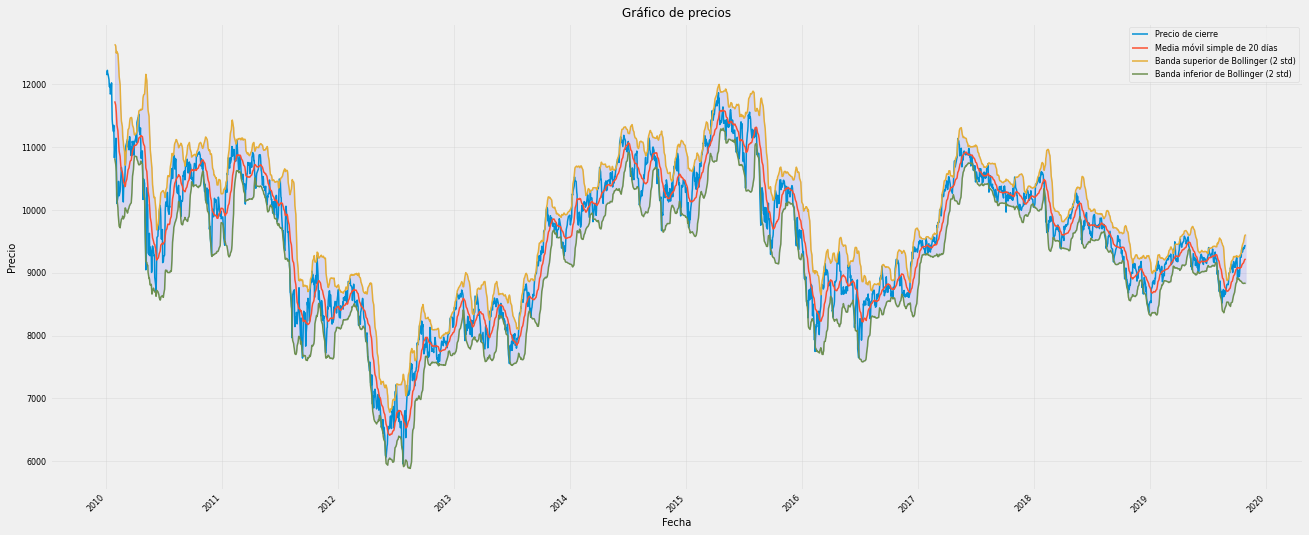

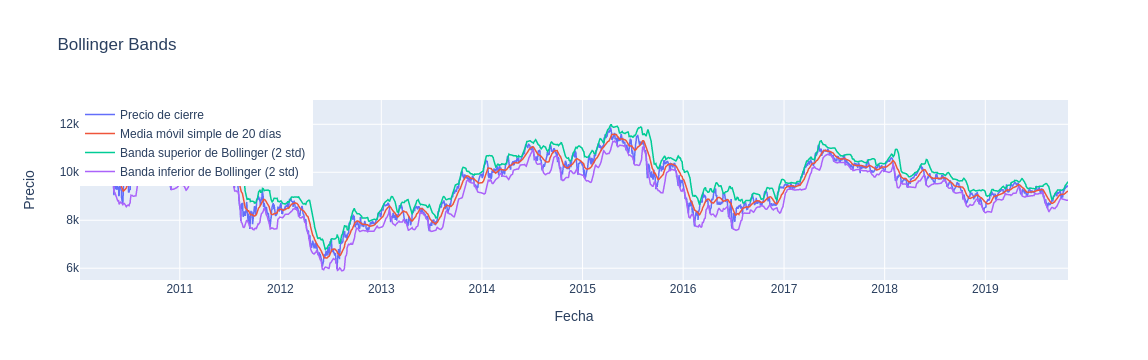

In [80]:
# Gráfica con matplotlib.
bb.matplotlib_plot()
# Gráfica con plotly.
bb.plotly_plot()

# Nota de advertencias.
Este notebook tiene fines educativos y de demostración solamente. Las estrategias de inversión presentadas aquí son ejemplos y pueden contener errores. Se recomienda encarecidamente que cualquier decisión de inversión se tome después de consultar con un asesor financiero calificado. No se proporciona asesoramiento financiero, y cualquier uso de la información presentada es bajo su propio riesgo. Agradecemos cualquier retroalimentación para mejorar la calidad de estos ejemplos.  
Es importante recordar que no hay una estrategia única que funcione en todos los casos, y siempre hay un riesgo asociado con la inversión. Es recomendable realizar pruebas exhaustivas y análisis antes de implementar cualquier estrategia en un entorno de trading real.